In [1]:
pip install numpy matplotlib pandas tensorflow seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
import seaborn as sns
import matplotlib.gridspec as gridspec

In [3]:
from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

In [6]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

In [47]:
# Importing benign gafgyt combo dataset for a given device id (1-9)
def import_dataset_benign_gagfyt_combo(device_id):
    normal = pd.read_csv('{}.benign.csv'.format(device_id))
    n_X = normal.iloc[:,]
    n_X_scaled = MinMaxScaler().fit_transform(n_X.values)
    n_y = np.ones(n_X.shape[0]) # 1 represents normal

    anomalous = pd.read_csv('{}.gafgyt.combo.csv'.format(device_id))
    a_X = anomalous.iloc[:,]
    a_X_scaled = MinMaxScaler().fit_transform(a_X.values)
    a_y = np.zeros(a_X.shape[0]) # 0 represents anomalous

    #normal.info()
    #normal.describe()
    #normal.head()

    #anomalous.info()
    #anomalous.describe()
    #anomalous.head()

    return (n_X_scaled, n_y, a_X_scaled, a_y)

In [48]:
def generate_and_train_autoencoder(X):
    ## input layer
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")

    autoencoder.fit(X[0:1000], X[0:1000],
                    batch_size = 256, epochs = 10,
                    shuffle = True, validation_split = 0.20);

    return autoencoder

In [49]:
# hidden representation
def get_hidden_representation_normal_anomalous(autoencoder, n_X, a_X):
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    normal_hid_rep = hidden_representation.predict(n_X[:3000])
    anomalous_hid_rep = hidden_representation.predict(a_X[:3000])

    return (normal_hid_rep, anomalous_hid_rep)

In [50]:
def tsne_plot(x, y, title="Scatter Plot", name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Anomalous')

    plt.title(title)
    plt.legend(loc='best');
    plt.savefig('{}-{}'.format(title,name));
    plt.show();

In [51]:
# Combine normal and anomalous data
def combine_normal_anomalous(normal, anomalous):
    X = np.append(normal, anomalous, axis = 0)
    y_n = np.ones(normal.shape[0])
    y_a = np.zeros(anomalous.shape[0])
    y = np.append(y_n, y_a)

    return (X, y)

In [52]:
def show_confusion_matrix(test, pred):
  conf_matrix = confusion_matrix(test, pred)
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['Nomal', 'Anomalous'],
              yticklabels=['Nomal', 'Anomalous'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [53]:
# Evaluate model's performace
def evaluate_model(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
    clf = LogisticRegression(solver="lbfgs").fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    return (test_y, pred_y)

In [54]:
# Show model's report
def show_model_report(title, X, y, hid_X, hid_y, test_y, pred_y):
    #tsne_plot(X, y, '{}-original'.format(title), "original.png")
    tsne_plot(hid_X, hid_y, title, "hidden_representation.png")

    print(title)
    print ("")
    print ("Classification Report: ")
    print (classification_report(test_y, pred_y))

    print ("")
    print ("Accuracy Score: ", accuracy_score(test_y, pred_y))

In [55]:
# Detect zero-day attack
def detect_zero_day_attack(device_name, device_id):
    (n_X_scaled, n_y, a_X_scaled, a_y) = import_dataset_benign_gagfyt_combo(device_id)
    autoencoder = generate_and_train_autoencoder(n_X_scaled)
    (normal_hid_rep, anomalous_hid_rep) = get_hidden_representation_normal_anomalous(autoencoder, n_X_scaled, a_X_scaled)
    (X, y) = combine_normal_anomalous(n_X_scaled, a_X_scaled)
    (hid_X, hid_y) = combine_normal_anomalous(normal_hid_rep, anomalous_hid_rep)
    (test_y, pred_y) = evaluate_model(hid_X, hid_y)

    show_model_report(device_name, X, y, hid_X, hid_y, test_y, pred_y)
    show_confusion_matrix(test_y, pred_y)

Epoch 1/10
4/4 [==============================] - 21s 1s/step - loss: 0.0470 - val_loss: 0.0443
Epoch 2/10
4/4 [==============================] - 1s 261ms/step - loss: 0.0470 - val_loss: 0.0443
Epoch 3/10
4/4 [==============================] - 1s 249ms/step - loss: 0.0469 - val_loss: 0.0443
Epoch 4/10
4/4 [==============================] - 1s 438ms/step - loss: 0.0469 - val_loss: 0.0443
Epoch 5/10
4/4 [==============================] - 1s 331ms/step - loss: 0.0469 - val_loss: 0.0442
Epoch 6/10
4/4 [==============================] - 1s 339ms/step - loss: 0.0469 - val_loss: 0.0442
Epoch 7/10
4/4 [==============================] - 1s 243ms/step - loss: 0.0469 - val_loss: 0.0442
Epoch 8/10
4/4 [==============================] - 1s 278ms/step - loss: 0.0469 - val_loss: 0.0442
Epoch 9/10
4/4 [==============================] - 1s 253ms/step - loss: 0.0468 - val_loss: 0.0442
Epoch 10/10
94/94 [==============================] - 3s 24ms/step


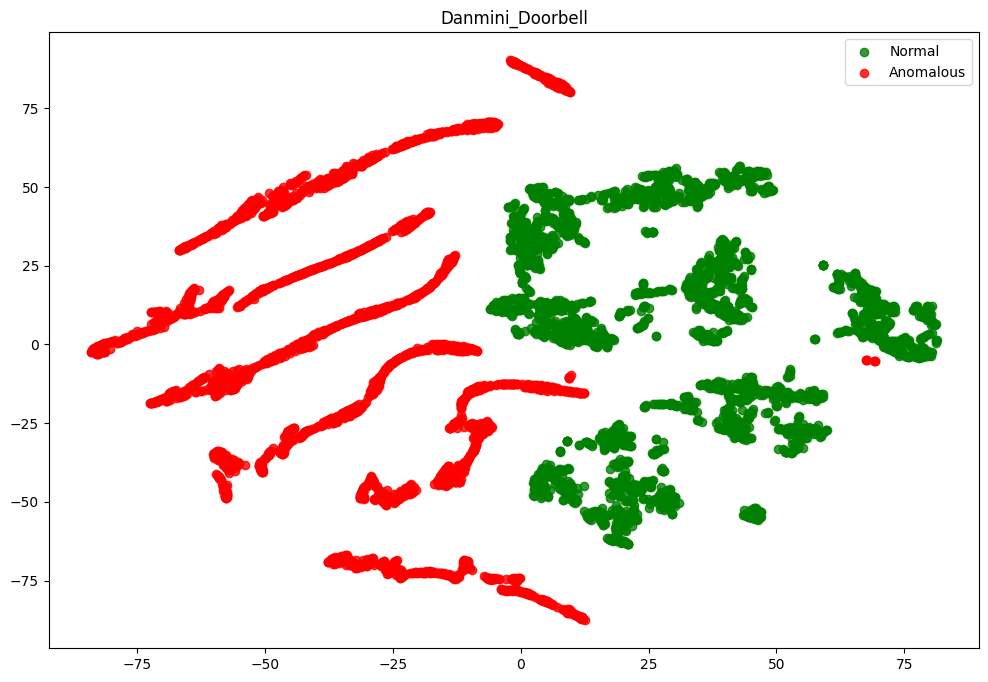

Danmini_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       739
         1.0       1.00      1.00      1.00       761

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.998


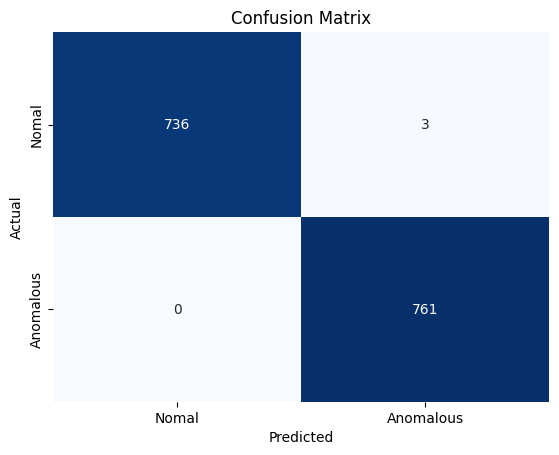

Epoch 1/10
4/4 [==============================] - 3s 229ms/step - loss: 0.0895 - val_loss: 0.0826
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0895 - val_loss: 0.0826
Epoch 3/10
4/4 [==============================] - 0s 41ms/step - loss: 0.0895 - val_loss: 0.0826
Epoch 4/10
4/4 [==============================] - 0s 52ms/step - loss: 0.0894 - val_loss: 0.0825
Epoch 5/10
4/4 [==============================] - 0s 53ms/step - loss: 0.0894 - val_loss: 0.0825
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0894 - val_loss: 0.0825
Epoch 7/10
4/4 [==============================] - 0s 38ms/step - loss: 0.0894 - val_loss: 0.0825
Epoch 8/10
4/4 [==============================] - 0s 37ms/step - loss: 0.0894 - val_loss: 0.0825
Epoch 9/10
4/4 [==============================] - 0s 36ms/step - loss: 0.0893 - val_loss: 0.0824
Epoch 10/10
94/94 [==============================] - 0s 4ms/step


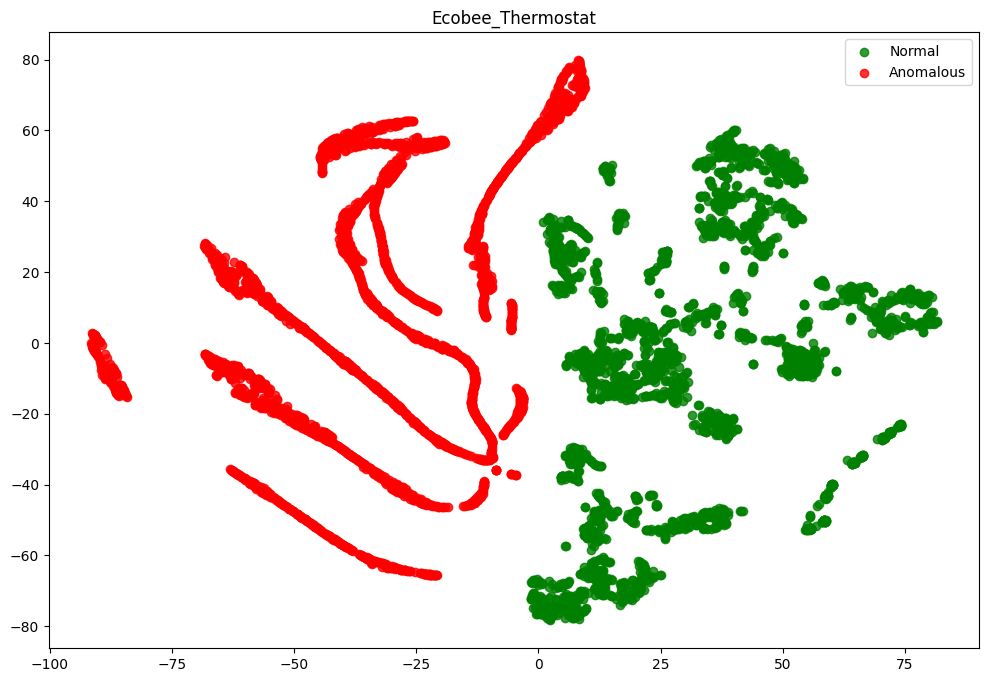

Ecobee_Thermostat

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       722
         1.0       1.00      1.00      1.00       778

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


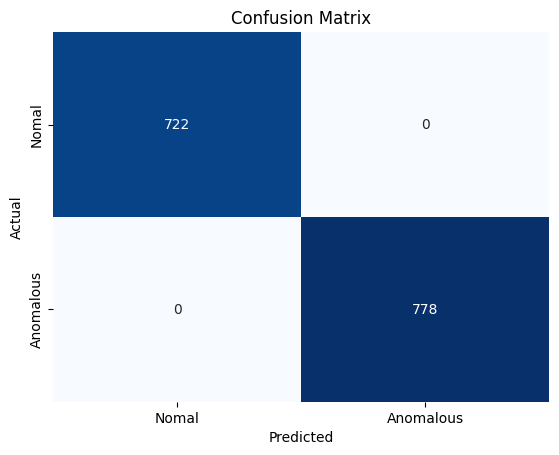

Epoch 1/10
4/4 [==============================] - 5s 245ms/step - loss: 0.0983 - val_loss: 0.0949
Epoch 2/10
4/4 [==============================] - 0s 46ms/step - loss: 0.0982 - val_loss: 0.0949
Epoch 3/10
4/4 [==============================] - 0s 65ms/step - loss: 0.0982 - val_loss: 0.0948
Epoch 4/10
4/4 [==============================] - 0s 76ms/step - loss: 0.0981 - val_loss: 0.0948
Epoch 5/10
4/4 [==============================] - 0s 85ms/step - loss: 0.0981 - val_loss: 0.0948
Epoch 6/10
4/4 [==============================] - 0s 83ms/step - loss: 0.0981 - val_loss: 0.0947
Epoch 7/10
4/4 [==============================] - 0s 85ms/step - loss: 0.0980 - val_loss: 0.0947
Epoch 8/10
4/4 [==============================] - 0s 65ms/step - loss: 0.0980 - val_loss: 0.0946
Epoch 9/10
4/4 [==============================] - 0s 65ms/step - loss: 0.0979 - val_loss: 0.0946
Epoch 10/10
94/94 [==============================] - 1s 5ms/step


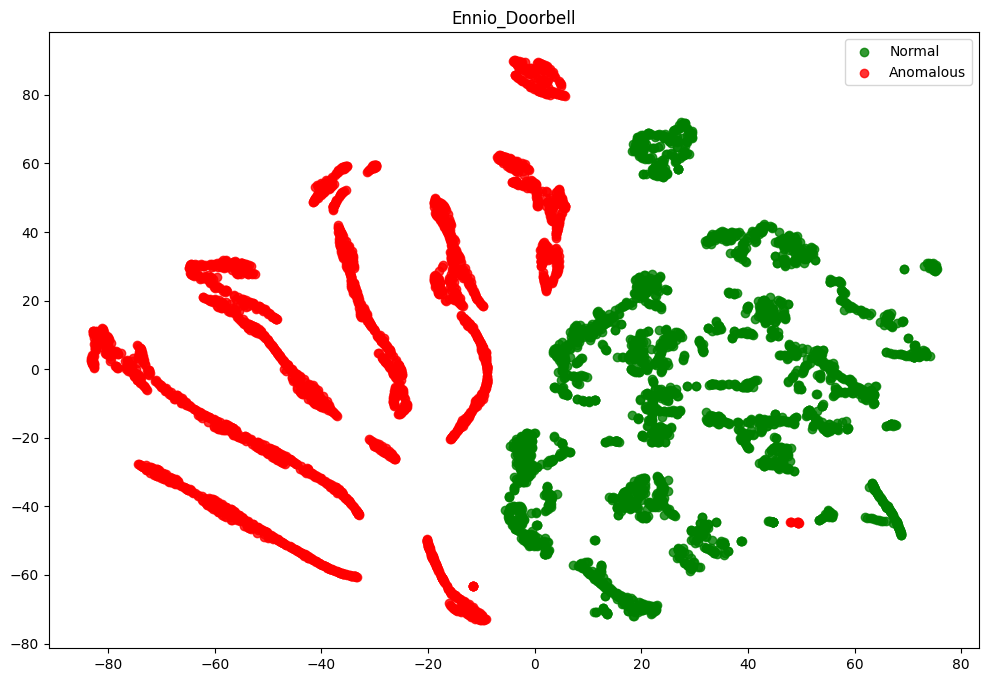

Ennio_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       781
         1.0       1.00      1.00      1.00       719

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0


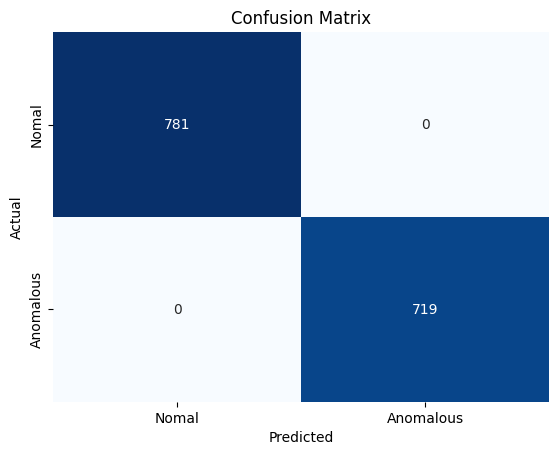

Epoch 1/10
4/4 [==============================] - 4s 206ms/step - loss: 0.2886 - val_loss: 0.1709
Epoch 2/10
4/4 [==============================] - 0s 65ms/step - loss: 0.2885 - val_loss: 0.1709
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: 0.2883 - val_loss: 0.1708
Epoch 4/10
4/4 [==============================] - 0s 44ms/step - loss: 0.2882 - val_loss: 0.1708
Epoch 5/10
4/4 [==============================] - 0s 71ms/step - loss: 0.2880 - val_loss: 0.1708
Epoch 6/10
4/4 [==============================] - 0s 41ms/step - loss: 0.2879 - val_loss: 0.1707
Epoch 7/10
4/4 [==============================] - 0s 63ms/step - loss: 0.2877 - val_loss: 0.1707
Epoch 8/10
4/4 [==============================] - 0s 56ms/step - loss: 0.2875 - val_loss: 0.1707
Epoch 9/10
4/4 [==============================] - 0s 50ms/step - loss: 0.2874 - val_loss: 0.1706
Epoch 10/10
94/94 [==============================] - 1s 5ms/step


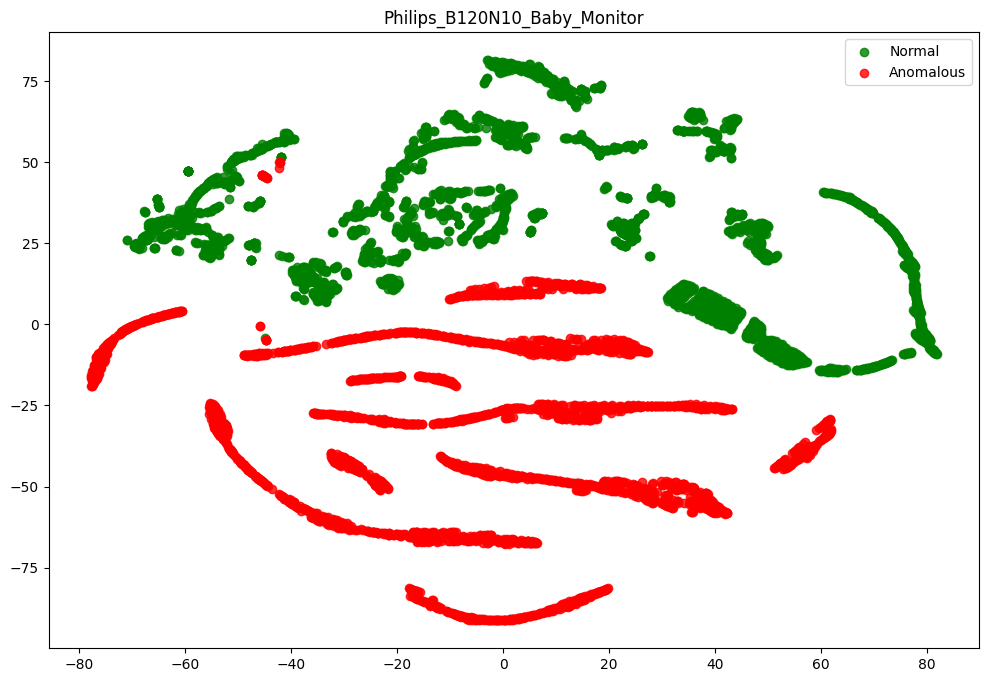

Philips_B120N10_Baby_Monitor

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       1.00      1.00      1.00       742

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9986666666666667


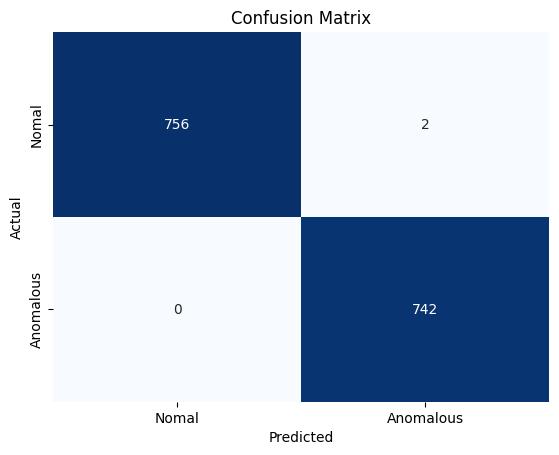

FileNotFoundError: [Errno 2] No such file or directory: '5.benign.csv'

In [56]:
devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']
#devices = ['Danmini_Doorbell', 'Ecobee_Thermostat']
for device_id, device_name in enumerate(devices, 1):
    detect_zero_day_attack(device_name, device_id)